# Understanding School Performance on Pennsylvania Standardized Tests

## Preprocessing and Baseline Modeling

The objective of this notebook is to build a baseline model and generate metrics to use as a reference point to build on. To do so, we will finalize our design matrix and target vectors, and split them into training and testing datasets.  For our baseline model, we will be using sklearn's Linear Regression algorithm.

Along the way, we will also scale our features and train/test our linear regression algorithm on both unscaled and scaled data.  Additionally, we will also assess the pairwise collinearity of the features in our design matrix, and create a list of features to potentially drop in the next notebook on extended modeling.

Upon analyzing the results of our baseline models and the evaluation metrics, we will create a plan at the end of this notebook for extended modeling to be completed in the next notebook.

### Contents:

1. [Import packages and load data](#section1)
2. [Assess pairwise collinearity](#section2)
3. [Train test split](#section3)
4. [Feature scaling](#section4)
5. [Baseline modeling](#section5)
6. [Plan for extended modeling](#section6)


<a id='section1'></a>
## 1. Import packages and load data

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
# load cleaned data from csv file
df = pd.read_csv('../Data/school_data_1819_2.csv', index_col = 0)

In [3]:
# check columns
df.columns

Index(['SchoolName', 'SchoolNumber', 'School Zip Code', 'DistrictName', 'AUN',
       'Title I School', 'Title I (Binary)', 'School Enrollment',
       'Male (School)', 'Female (School)',
       'Percent Regular Attendance (All Student)',
       'American Indian/Alaskan Native', 'Asian', 'Black/African American',
       'Hispanic', 'Native Hawaiian or other Pacific Islander', 'White',
       '2 or More Races', 'English Learner', 'Special Education',
       'Percent of Gifted Students', 'Economically Disadvantaged',
       'Foster Care', 'Homeless', 'Military Connected',
       'Local - Non-Personnel', 'Local - Personnel', 'Total Local Expenditure',
       'State - Non-Personnel', 'State - Personnel', 'Total State Expenditure',
       'Federal - Non-Personnel', 'Federal - Personnel',
       'Total Federal Expenditure', 'Total Non-Personnel Expenditure',
       'Total Personnel Expenditure', 'Total Expenditure',
       'Percent Proficient or Advanced ELA/Literature (All Student)',
      

In [4]:
# establish design matrix, call it 'predictors'
predictors = df.drop(['SchoolName', \
                      'SchoolNumber', \
                      'School Zip Code', \
                      'DistrictName', \
                      'AUN', \
                      'Title I School', \
                      'Percent Proficient or Advanced ELA/Literature (All Student)', \
                      'Percent Proficient or Advanced Mathematics/Algebra 1 (All Student)'], \
                     axis = 1) 

# target vectors
target_ELA = df['Percent Proficient or Advanced ELA/Literature (All Student)']
target_math = df['Percent Proficient or Advanced Mathematics/Algebra 1 (All Student)']

In [5]:
#check datatypes of predictors
predictors.dtypes

Title I (Binary)                               int64
School Enrollment                              int64
Male (School)                                float64
Female (School)                              float64
Percent Regular Attendance (All Student)     float64
American Indian/Alaskan Native               float64
Asian                                        float64
Black/African American                       float64
Hispanic                                     float64
Native Hawaiian or other Pacific Islander    float64
White                                        float64
2 or More Races                              float64
English Learner                              float64
Special Education                            float64
Percent of Gifted Students                   float64
Economically Disadvantaged                   float64
Foster Care                                  float64
Homeless                                     float64
Military Connected                           f

<a id='section2'></a>
## 2. Assess pairwise collinearity

As we observed in the previous notebook, there are quite a few of our independent variables that are correlated with another.  With that in mind, there is concern that this may lead to overfitting and an increase in the error of our model. 

By looking at the pairwise collinearity of our variables, we can identify and place feature pairs in one of three buckets based on the correlation coefficients:

- $|r|$ is <b>0.5 or below:</b> low correlation
- $|r|$ is between <b>0.5 and 0.7:</b> mid correlation
- $|r|$ is <b>0.7 and above:</b> high correlation

We will look at the mid correlation and high correlation buckets and determine any features that may potentially be deleted and generate a list.

In our next notebook (extended modeling), we will train, test, and compare models with all features included vs highly correlated features removed.  We will also explore models such as ridge regression and LASSO regression that can introduce penalization on information that is redundant.

In [6]:
# Construct correlation matrix and take the absolute value of all correlation coefficients
corr_abs = predictors.corr().abs()

# Select upper triangle of correlation matrix
upper_corr_abs = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

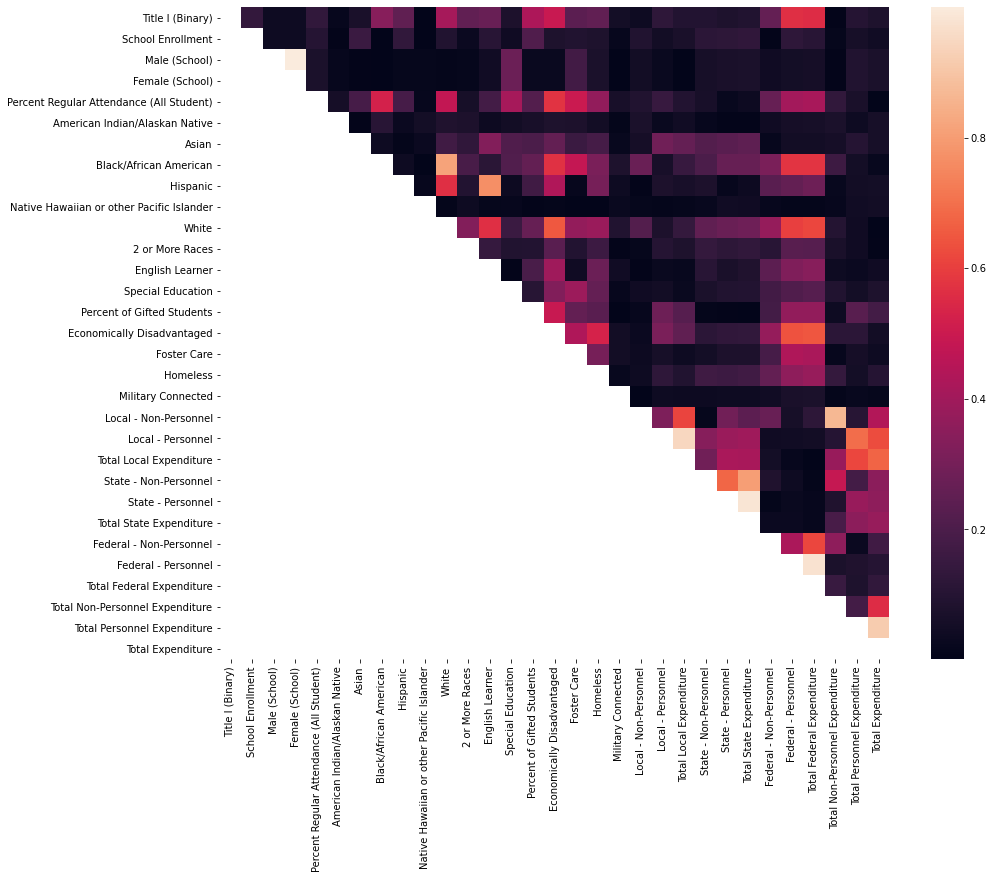

In [7]:
# plot the correlation heatmap
plt.subplots(figsize=(15,12))
sns.heatmap(upper_corr_abs)
plt.show()

Looking at this heatmap of pairwise correlation, there definitely exist predictor variables that are highly correlated with another. 

We'll create three functions that will take this correlation matrix and identify which pairs of features are highly correlated, somewhat correlated, and not very correlated.

In [8]:
def high_corr(correlation_matrix, high_threshold):
    """creates a list of feature pairs as tuples that are highly correlated"""
    
    high_corr_list = []
    
    for i in range(len(correlation_matrix)):
    #iterate through 'i' rows
    
        for j in range(len(correlation_matrix)):
        #iterate through 'j' columns
            if correlation_matrix.iloc[i][j] > high_threshold:
                high_corr_list.append((correlation_matrix.index[i], correlation_matrix.columns[j], round(correlation_matrix.iloc[i][j], 4)))
    
    return high_corr_list


def mid_corr(correlation_matrix, mid_threshold, high_threshold):
    """creates a list of feature pairs as tuples that are somewhat correlated"""
    
    mid_corr_list = []
    
    for i in range(len(correlation_matrix)):
    #iterate through 'i' rows
    
        for j in range(len(correlation_matrix)):
        #iterate through 'j' columns
            if correlation_matrix.iloc[i][j] > mid_threshold and correlation_matrix.iloc[i][j] <= high_threshold:
                mid_corr_list.append((correlation_matrix.index[i], correlation_matrix.columns[j], round(correlation_matrix.iloc[i][j], 4)))
    
    return mid_corr_list


def low_corr(correlation_matrix, mid_threshold):
    """creates a list of feature pairs as tuples that have low correlation"""
    
    low_corr_list = []
    
    for i in range(len(correlation_matrix)):
    #iterate through 'i' rows
    
        for j in range(len(correlation_matrix)):
        #iterate through 'j' columns
            if correlation_matrix.iloc[i][j] <= mid_threshold:
                low_corr_list.append((correlation_matrix.index[i], correlation_matrix.columns[j], round(correlation_matrix.iloc[i][j], 4)))
    
    return low_corr_list

Now that we have the functions defined, we'll examine the pairwise collinearity of our dataset.

In [9]:
# create list of feature pairs with |r|<0.5
low_corr_pairs = low_corr(upper_corr_abs, 0.5)
low_corr_pairs

[('Title I (Binary)', 'School Enrollment', 0.1363),
 ('Title I (Binary)', 'Male (School)', 0.0385),
 ('Title I (Binary)', 'Female (School)', 0.0385),
 ('Title I (Binary)', 'Percent Regular Attendance (All Student)', 0.1328),
 ('Title I (Binary)', 'American Indian/Alaskan Native', 0.019),
 ('Title I (Binary)', 'Asian', 0.0689),
 ('Title I (Binary)', 'Black/African American', 0.3422),
 ('Title I (Binary)', 'Hispanic', 0.2471),
 ('Title I (Binary)', 'Native Hawaiian or other Pacific Islander', 0.0026),
 ('Title I (Binary)', 'White', 0.4123),
 ('Title I (Binary)', '2 or More Races', 0.2533),
 ('Title I (Binary)', 'English Learner', 0.2693),
 ('Title I (Binary)', 'Special Education', 0.0792),
 ('Title I (Binary)', 'Percent of Gifted Students', 0.43),
 ('Title I (Binary)', 'Economically Disadvantaged', 0.4959),
 ('Title I (Binary)', 'Foster Care', 0.2375),
 ('Title I (Binary)', 'Homeless', 0.2545),
 ('Title I (Binary)', 'Military Connected', 0.055),
 ('Title I (Binary)', 'Local - Non-Personn

In [10]:
# create list of feature pairs with 0.5<|r|<0.7
mid_corr_pairs = mid_corr(upper_corr_abs, 0.5, 0.7)
mid_corr_pairs

[('Title I (Binary)', 'Federal - Personnel', 0.564),
 ('Title I (Binary)', 'Total Federal Expenditure', 0.5554),
 ('Percent Regular Attendance (All Student)',
  'Black/African American',
  0.5249),
 ('Percent Regular Attendance (All Student)',
  'Economically Disadvantaged',
  0.5739),
 ('Black/African American', 'Economically Disadvantaged', 0.5677),
 ('Black/African American', 'Federal - Personnel', 0.5756),
 ('Black/African American', 'Total Federal Expenditure', 0.5777),
 ('Hispanic', 'White', 0.5649),
 ('White', 'English Learner', 0.566),
 ('White', 'Economically Disadvantaged', 0.6524),
 ('White', 'Federal - Personnel', 0.6012),
 ('White', 'Total Federal Expenditure', 0.6155),
 ('Economically Disadvantaged', 'Homeless', 0.5312),
 ('Economically Disadvantaged', 'Federal - Personnel', 0.6379),
 ('Economically Disadvantaged', 'Total Federal Expenditure', 0.6472),
 ('Local - Non-Personnel', 'Total Local Expenditure', 0.6102),
 ('Local - Personnel', 'Total Personnel Expenditure', 0.69

In [11]:
# create list of feature pairs with |r|>0.7
high_corr_pairs = high_corr(upper_corr_abs, 0.7)
high_corr_pairs

[('Male (School)', 'Female (School)', 1.0),
 ('Black/African American', 'White', 0.8143),
 ('Hispanic', 'English Learner', 0.7677),
 ('Local - Non-Personnel', 'Total Non-Personnel Expenditure', 0.8637),
 ('Local - Personnel', 'Total Local Expenditure', 0.9461),
 ('State - Non-Personnel', 'Total State Expenditure', 0.8016),
 ('State - Personnel', 'Total State Expenditure', 0.9832),
 ('Federal - Personnel', 'Total Federal Expenditure', 0.9747),
 ('Total Personnel Expenditure', 'Total Expenditure', 0.9164)]

As expected, we have a few feature pairs that are highly correlated.  Certainly the percentage of male students and percentage of female students will have a correlation coefficient that is close to, if not equal to -1.  We're also seeing that the percentage of black students and percentage of white students are also strongly correlated. 

Most of the high correlation feature pairs are a result of the various 'Total' expenditure columns that we created during EDA.  

Among the <b>second</b> element of the high correlation pairs, the only total that seems to be missing is 'Total Personnel Expenditure'.  We notice that when we look at the mid-correlation pairs, that 'Local - Personnel' and 'Total Personnel Expenditure' have a correlation coefficient of 0.694.  

If we are removing our engineered 'Total' expenditure features, it may make sense to remove all of them.  As a result, we will run our function again, but with a threshold of 0.69.

In [12]:
high_corr_pairs_2 = high_corr(upper_corr_abs, 0.69)
high_corr_pairs_2

[('Male (School)', 'Female (School)', 1.0),
 ('Black/African American', 'White', 0.8143),
 ('Hispanic', 'English Learner', 0.7677),
 ('Local - Non-Personnel', 'Total Non-Personnel Expenditure', 0.8637),
 ('Local - Personnel', 'Total Local Expenditure', 0.9461),
 ('Local - Personnel', 'Total Personnel Expenditure', 0.694),
 ('State - Non-Personnel', 'Total State Expenditure', 0.8016),
 ('State - Personnel', 'Total State Expenditure', 0.9832),
 ('Federal - Personnel', 'Total Federal Expenditure', 0.9747),
 ('Total Personnel Expenditure', 'Total Expenditure', 0.9164)]

We'll create a list of features to potentially delete.  To do so, we'll select the second feature from each tuple pair.

Then, we'll create a new design matrix without these features.

In [13]:
# create an empty list of features to potentially delete
corr_features = []

# iterate through our high_corr_pairs list and add the second item of each tuple to our corr_features list
for tup in high_corr_pairs_2:
    corr_features.append(tup[1])

In [14]:
# use the 'set' data structure to elimnate any duplicates
corr_features = list(set(corr_features))
corr_features

['English Learner',
 'Total Personnel Expenditure',
 'Female (School)',
 'Total Local Expenditure',
 'White',
 'Total State Expenditure',
 'Total Non-Personnel Expenditure',
 'Total Federal Expenditure',
 'Total Expenditure']

We'll save this list for our next notebook on extended modeling.

In [15]:
import pickle

# save list in Data directory as corr_features.pkl
with open('../Data/corr_features.pkl', 'wb') as f:
    pickle.dump(corr_features, f)

<a id='section3'></a>
## 3. Train Test Split

We'll split our dataset into an 80/20 train/test split ratio.  We'll do this two times, one for the ELA performance target variable and the other for the math performance target variable.  

In order to ensure that the design matrix will be split consistently, we will use a random_state of 16 for both splits, and then confirm that the X_trains and X_tests are indeed identical dataframes.

In [16]:
#Check partition sizes with 80/20 train/test split
print(len(predictors) * .8, len(predictors) * .2)

2138.4 534.6


In [17]:
# create train test split with original predictors and ELA as the target variable
X_train_ELA, X_test_ELA, y_train_ELA, y_test_ELA = train_test_split(predictors, 
                                                                    target_ELA, 
                                                                    test_size=0.2, 
                                                                    random_state=16)

In [18]:
#check partition size
X_train_ELA.shape, X_test_ELA.shape

((2138, 31), (535, 31))

In [19]:
#check partition size
y_train_ELA.shape, y_test_ELA.shape

((2138,), (535,))

In [20]:
# create train test split with original predictors and math as the target variable
X_train_math, X_test_math, y_train_math, y_test_math = train_test_split(predictors,
                                                                        target_math,
                                                                        test_size=0.2,
                                                                        random_state=16
                                                                       )

Since we are using the same random state for both of these train/test splits, X_train_ELA and X_train_math should be identical, and the same should hold true for X_test_ELA and X_test_math.  But we will check to be sure.

In [21]:
#confirm that X_train_ELA and X_train_math are equivalent dataframes

from pandas.testing import assert_frame_equal

assert_frame_equal(X_train_ELA, X_train_math)

In [22]:
#confirm that X_test_ELA and X_test_math are equivalent dataframes
assert_frame_equal(X_test_ELA, X_test_math)

Since we've confirmed that X_train_ELA and X_train_math are equal (as well as X_test_ELA and X_test_math), we will simply use X_train and X_test to refer to both of them, for simplicity.

In [23]:
X_train = X_train_ELA
X_test = X_test_ELA

<a id='section4'></a>
## 4. Feature Scaling

Apply standard scaler since some of our variables do not have a defined maximum value (namely our expenditures).

To prevent potentially leaking information from our test set into the model, we will fit the scaler on only the training data and then standardize both the training and test sets with this scaler.

First, we will fit and apply the scaler to our original X_train and X_test datasets, which still retains all of our highly correlated features.

In [24]:
# instantiate standard scaler
sc1 = StandardScaler()

# fit the scaler on the training set and transform it
X_train_sc = sc1.fit_transform(X_train)

# transform the test set
X_test_sc = sc1.transform(X_test)

<a id='section5'></a>
## 5. Baseline Modeling

For our initial baseline models, we will be using Linear Regression.  For both ELA and math, we will construct two models, one with unscaled data and the other with scaled data.  

As a result, we have 4 models to train and test.  The table below shows all of the combinations, as well as the corresponding datasets used to train and test.

| Scaling | Subject | X train | X test | y train | y test |
| --- | --- | --- | --- | --- | --- |
| Unscaled | ELA | X_train | X_test | y_train_ELA | y_test_ELA |
| Scaled | ELA | X_train_sc | X_test_sc | y_train_ELA | y_test_ELA |
| Unscaled | Math | X_train | X_test | y_train_math | y_test_math |
| Scaled | Math | X_train_sc | X_test_sc | y_train_math | y_test_math |


For easier comparison, we will set up a table to compare metrics and define a function that will add the metrics of each model to this table.

In [25]:
# set up column names for metrics table
column_names = ["Subject", "Scaling", "Train r2", "Train MAE", "Train RMSE", "Test r2", "Test MAE", "Test RMSE"]

# create dataframe for metrics table with column names listed above
metrics = pd.DataFrame(columns = column_names)

In [26]:
def add_metrics(Subject, Scaling, y_train, y_train_pred, y_test, y_test_pred):
    
    new_row = {'Subject':Subject,
               'Scaling':Scaling,
               'Train r2': r2_score(y_train, y_train_pred),
               'Train MAE': mean_absolute_error(y_train, y_train_pred),
               'Train RMSE': mean_squared_error(y_train, y_train_pred, squared = False),
               'Test r2': r2_score(y_test, y_test_pred),
               'Test MAE': mean_absolute_error(y_test, y_test_pred),
               'Test RMSE': mean_squared_error(y_test, y_test_pred, squared = False)}
    
    global metrics
    
    metrics = metrics.append(new_row, ignore_index = True)

### 5a. Target = ELA performance, unscaled data

In [27]:
# instantiate LinearRegression for ELA
lr1_ELA = LinearRegression()

#fit on training data for ELA
lr1_ELA.fit(X_train, y_train_ELA)

# predict on train set and test set
y_train_ELA_pred = lr1_ELA.predict(X_train)
y_test_ELA_pred = lr1_ELA.predict(X_test)

In [28]:
add_metrics('ELA','Unscaled', y_train_ELA, y_train_ELA_pred, y_test_ELA, y_test_ELA_pred)

### 5b. Target = ELA performance, scaled data

In [29]:
# instantiate LinearRegression for ELA
lr2_ELA = LinearRegression()

#fit on training data for ELA
lr2_ELA.fit(X_train_sc, y_train_ELA)

# predict on train set and test set
y_train_ELA_pred2 = lr2_ELA.predict(X_train_sc)
y_test_ELA_pred2 = lr2_ELA.predict(X_test_sc)

In [30]:
add_metrics('ELA', 'Scaled', y_train_ELA, y_train_ELA_pred2, y_test_ELA, y_test_ELA_pred2)

### 5c. Target = math performance, unscaled data

In [31]:
# instantiate LinearRegression for math
lr1_math = LinearRegression()

#fit on training data for math
lr1_math.fit(X_train, y_train_math)

# predict on train set and test set
y_train_math_pred = lr1_math.predict(X_train)
y_test_math_pred = lr1_math.predict(X_test)

In [32]:
add_metrics('Math', 'Unscaled', y_train_math, y_train_math_pred, y_test_math, y_test_math_pred)

### 5d. Target = math performance, scaled data

In [33]:
# instantiate LinearRegression for math
lr2_math = LinearRegression()

#fit on training data for ELA
lr2_math.fit(X_train_sc, y_train_math)

# predict on train set and test set
y_train_math_pred2 = lr2_math.predict(X_train_sc)
y_test_math_pred2 = lr2_math.predict(X_test_sc)

In [34]:
add_metrics('Math', 'Scaled', y_train_math, y_train_math_pred2, y_test_math, y_test_math_pred2)

In [35]:
metrics

,Subject,Scaling,Train r2,Train MAE,Train RMSE,Test r2,Test MAE,Test RMSE
0,ELA,Unscaled,0.817979,6.346800,8.218406,0.786248,6.775300,8.857606
1,ELA,Scaled,0.799005,6.677475,8.636123,0.771052,6.948462,9.167040
2,Math,Unscaled,0.692955,9.810908,12.207158,0.655520,10.215045,12.842383
3,Math,Scaled,0.700370,9.679650,12.058856,0.655321,10.117124,12.846087


Our models for ELA seem to perform better, with higher $r^2$ scores and lower MAE and RMSE compared to the models for math performance.  

If we are looking at the difference between models with scaled vs unscaled data, for the <i>most</i> part, it seems that our models with unscaled data performed better.  That being said, the difference was marginal.  

With that in mind, in our next notebook, we will simply use unscaled data for our models.

<a id='section6'></a>
## 6. Plan for extended modeling

Our objective for extended modeling will be to improve the performance of our models with respect to $r^2$ score, MAE, and RMSE.  In particular, we would like to see our performance on models for Percent Proficient or Advanced in Math improve.  A MAE score of approximately 10 percentage points gives too broad of a window for our predictions. 

The solution space for extended modeling for each of our two models (ELA performance and Math performance) is as follows:
- 2 different design matrices, one with all features retained, the other with highly correlated features removed
- 3 regression algorithms:
    - Linear Regression
    - Ridge Regression
    - LASSO Regression

This will give us 6 models to compare for each of our two target variables.  Additionally, after we identify the best performing models for each of our two target variables, we will apply hyperparameter tuning to the algorithms to see if we can further improve performance.

Ideally, we would like to see an $r^2$ score of at least 0.8 and a mean absolute error that is less than or equal to 5 percentage points.  With that said, we will also use the distribution of residual plots to help determine model selection.

In [36]:
# save train test split data
X_train.to_csv('../Data/X_train.csv')
X_test.to_csv('../Data/X_test.csv')

y_train_ELA.to_csv('../Data/y_train_ELA.csv')
y_test_ELA.to_csv('../Data/y_test_ELA.csv')

y_train_math.to_csv('../Data/y_train_math.csv')
y_test_math.to_csv('../Data/y_test_math.csv')